## Filter ERA5 just for station locations

In [2]:
import xarray as xr
import numpy as np

In [3]:
# GESLA dataset
file_path = "/Users/lb962/Downloads/ESL/GESLA/data/processed/GESLA/interim/GESLA3_NorthSeaShort.nc"
# Open the dataset
GESLA_ns_dataset = xr.open_dataset(file_path)
GESLA_ns_dataset = GESLA_ns_dataset[["sea_level", "latitude", "longitude"]]

# Open ERA5

In [4]:
import os
import xarray as xr

# Define the path to the folder containing the NetCDF files
folder_path = '/Users/lb962/Downloads/ESL/GESLA/data/ERA5hourly'

# Get a list of all NetCDF files in the folder
nc_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.nc')]

# Open all NetCDF files as a single xarray Dataset
ERA5_dataset = xr.open_mfdataset(nc_files)

In [6]:
# Assuming ERA5_dataset is your xarray dataset
coords = ERA5_dataset['mdts'].coords

print(coords)

Coordinates:
  * longitude  (longitude) float32 -11.5 -11.25 -11.0 -10.75 ... 14.5 14.75 15.0
  * latitude   (latitude) float32 48.0 48.25 48.5 48.75 ... 65.5 65.75 66.0
  * time       (time) datetime64[ns] 1990-01-01 ... 2014-12-31T23:00:00


In [7]:
import geopandas as gpd
from shapely.geometry import LineString

# Load coastline shapefile
coastline = gpd.read_file('/Users/lb962/Downloads/ESL/GESLA/data/Europe_coastline_shapefile (1)/Europe_coastline.shp')

# Define the projection
crs_etrs89 = "EPSG:3035"
crs_wgs84 = "EPSG:4326"

# Transform the coastline GeoDataFrame to longitude and latitude
coastline.to_crs(crs_wgs84, inplace=True)

# Define the longitude and latitude range for Europe
lon_min, lon_max = -11.5, 15.0  # Longitude range for Europe
lat_min, lat_max = 48, 65.0   # Latitude range for Europe

# Filter coastline points within the specified longitude and latitude range
coastline = coastline.cx[lon_min:lon_max, lat_min:lat_max]

# Define the interpolation interval range (in meters)
min_interval = 0.01  # Minimum interpolation interval
max_interval = 0.1  # Maximum interpolation interval

# Function to calculate adaptive interpolation interval based on segment length or curvature
def adaptive_interval(segment):
    segment_length = segment.length
    # Calculate curvature (ratio of segment length to chord length)
    chord_length = segment.distance(LineString([segment.coords[0], segment.coords[-1]]))
    curvature = segment_length / chord_length if chord_length != 0 else 0
    # Define a function to map curvature to interpolation interval within the specified range
    # Here, we use a simple linear mapping, but you can adjust this as needed
    mapped_interval = min_interval + (max_interval - min_interval) * (1 - curvature)
    # Ensure the interval is within the specified range
    return max(min(mapped_interval, max_interval), min_interval)

# Function to interpolate points along a line segment with adaptive interval
def interpolate_segment_adaptive(segment):
    # Calculate the adaptive interpolation interval for the segment
    interval = adaptive_interval(segment)
    # Calculate the number of interpolation points for the segment
    num_points = int(segment.length / interval) + 1
    # Interpolate points along the segment at adaptive intervals
    interpolated_points = [segment.interpolate(i * interval) for i in range(num_points)]
    return interpolated_points

# Interpolate points along each line segment of the MULTILINESTRING using adaptive interval
coastline_points_adaptive = []
for line in coastline.geometry:
    if line.geom_type == 'LineString':
        # If the geometry is a LineString, interpolate points along it
        coastline_points_adaptive.extend(interpolate_segment_adaptive(line))
    elif line.geom_type == 'MultiLineString':
        # If the geometry is a MultiLineString, iterate over its components and interpolate points along each segment
        for segment in line.geoms:
            coastline_points_adaptive.extend(interpolate_segment_adaptive(segment))

# Convert the coastline points to a GeoSeries
coastline_points = gpd.GeoSeries(coastline_points_adaptive)

# Filter the GeoSeries for points within the specified bounding box
coastline_points = coastline_points.cx[lon_min:lon_max, lat_min:lat_max]

In [8]:
coastline_points

19427    POINT (-4.56001 48.00052)
19450    POINT (-4.64684 48.02337)
19481    POINT (-4.83727 48.03038)
19482    POINT (-4.84585 48.03205)
19483    POINT (-4.84585 48.03205)
                   ...            
83840    POINT (11.49728 64.94504)
83841    POINT (11.51718 64.91158)
83842    POINT (11.59479 64.92404)
83843    POINT (11.58566 64.91326)
83844    POINT (11.55951 64.89751)
Length: 28997, dtype: geometry

In [9]:
import numpy as np

# Define a distance threshold
distance_threshold = 0.1  # You can adjust this threshold as needed

# List to store the close coordinates
close_coordinates = []

# Iterate over each point in coastline_points
for point in coastline_points:
    # Extract the longitude and latitude from the point
    lon, lat = point.x, point.y
    
    # Calculate distances between the point and all other points in the dataset
    distances = np.sqrt((lon - dataset.longitude)**2 + (lat - dataset.latitude)**2)
    
    # Find indices of points within the distance threshold
    close_indices = np.where(distances < distance_threshold)
    
    # Create 2D arrays of latitude and longitude indices
    lon_indices, lat_indices = np.meshgrid(close_indices[0], close_indices[1], indexing='ij')
    
    # Append the close coordinates to the list
    close_coordinates.extend(zip(dataset.longitude.values[lon_indices.flatten()], dataset.latitude.values[lat_indices.flatten()]))

# Convert the list to a set to remove duplicates and convert it back to a list
close_coordinates = list(set(close_coordinates))

# Now 'close_coordinates' contains the coordinate combinations close to the points in coastline_points

NameError: name 'dataset' is not defined

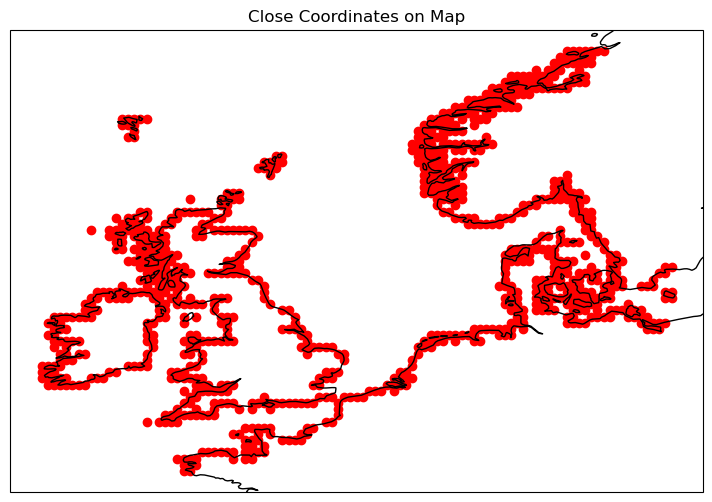

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Extract longitude and latitude from close_coordinates
lons, lats = zip(*close_coordinates)

# Create a map projection
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add coastlines
ax.coastlines()

# Plot coordinates
ax.scatter(lons, lats, color='red', marker='o', transform=ccrs.PlateCarree())

# Set title and show plot
ax.set_title('Close Coordinates on Map')
plt.show()


In [10]:
import numpy as np
import random

# Define the number of desired stations
num_desired_stations = 20

# Convert close_coordinates to numpy array for easier manipulation
close_coordinates_np = np.array(close_coordinates)

# Extract longitude and latitude arrays
lons, lats = close_coordinates_np[:, 0], close_coordinates_np[:, 1]

# Determine the minimum and maximum longitude and latitude
min_lon, max_lon = np.min(lons), np.max(lons)
min_lat, max_lat = np.min(lats), np.max(lats)

# Define the number of grid cells in each dimension
num_cells_x = int(np.sqrt(num_desired_stations))
num_cells_y = int(np.ceil(num_desired_stations / num_cells_x))

# Calculate the size of each grid cell
grid_cell_size_x = (max_lon - min_lon) / num_cells_x
grid_cell_size_y = (max_lat - min_lat) / num_cells_y

# Initialize lists to store selected station coordinates
selected_stations = []

# Iterate over each grid cell and select one coordinate
for i in range(num_cells_x):
    for j in range(num_cells_y):
        # Calculate the boundaries of the current grid cell
        cell_min_lon = min_lon + i * grid_cell_size_x
        cell_max_lon = min_lon + (i + 1) * grid_cell_size_x
        cell_min_lat = min_lat + j * grid_cell_size_y
        cell_max_lat = min_lat + (j + 1) * grid_cell_size_y
        
        # Find coordinates within the current grid cell
        mask = (lons >= cell_min_lon) & (lons < cell_max_lon) & \
               (lats >= cell_min_lat) & (lats < cell_max_lat)
        coordinates_in_cell = close_coordinates_np[mask]
        
        # If there are coordinates in the cell, select one randomly and add to the list
        if len(coordinates_in_cell) > 0:
            selected_stations.append(random.choice(coordinates_in_cell))

        # Break the loop if we have reached the desired number of stations
        if len(selected_stations) == num_desired_stations:
            break
    else:
        continue  # Continue if the inner loop wasn't broken
    break  # Break the outer loop if the desired number of stations is reached


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

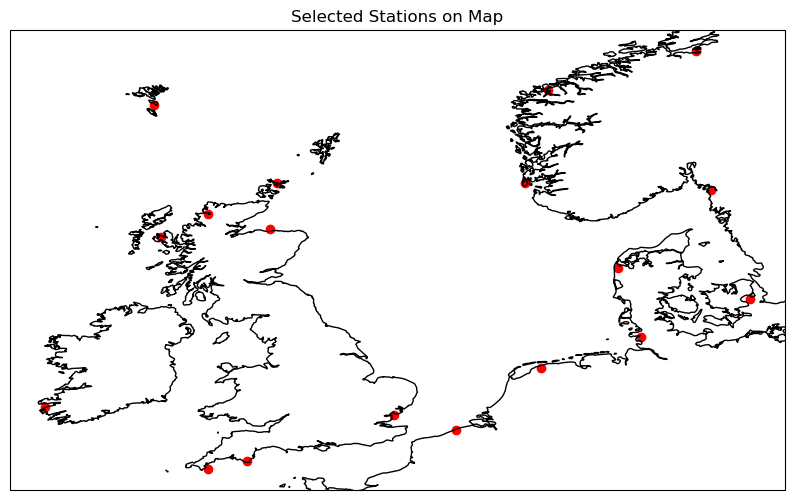

In [81]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Extract longitude and latitude from selected_stations
lons, lats = zip(*selected_stations)

# Create a map projection
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add coastlines
ax.coastlines()

# Plot stations
ax.scatter(lons, lats, color='red', marker='o', transform=ccrs.PlateCarree())

# Set title and show plot
ax.set_title('Selected Stations on Map')
plt.show()


In [1]:
len(selected_stations)

NameError: name 'selected_stations' is not defined

In [83]:
# Initialize a dictionary to store variables for each station
station_data = []

# Iterate over each selected station
for lon, lat in selected_stations:
    # Select data for the specific longitude and latitude
    selected_data = ERA5_dataset.sel(latitude=lat, longitude=lon)
    
    # Convert the selected data to a dictionary
    station_data.append(selected_data)

In [84]:
station_data

[<xarray.Dataset>
 Dimensions:    (time: 219144)
 Coordinates:
     longitude  float32 -5.0
     latitude   float32 50.0
   * time       (time) datetime64[ns] 1990-01-01 ... 2014-12-31T23:00:00
 Data variables:
     u10        (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
     v10        (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
     mdts       (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
     mpts       (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
     mwd        (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
     mwp        (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
     sst        (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
     shts       (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
     shww       (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
     sp         (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
 Attribut

In [ ]:
# Initialize an empty dictionary to store latitude and longitude information
station_coords = {}

# Iterate over each station in station_data
for idx, station in enumerate(station_data):
    # Extract latitude and longitude information
    latitude = station.latitude.values
    longitude = station.longitude.values
    
    # Add latitude and longitude information to the dictionary
    station_coords[idx] = latitude, longitude

station_coords[1][0]

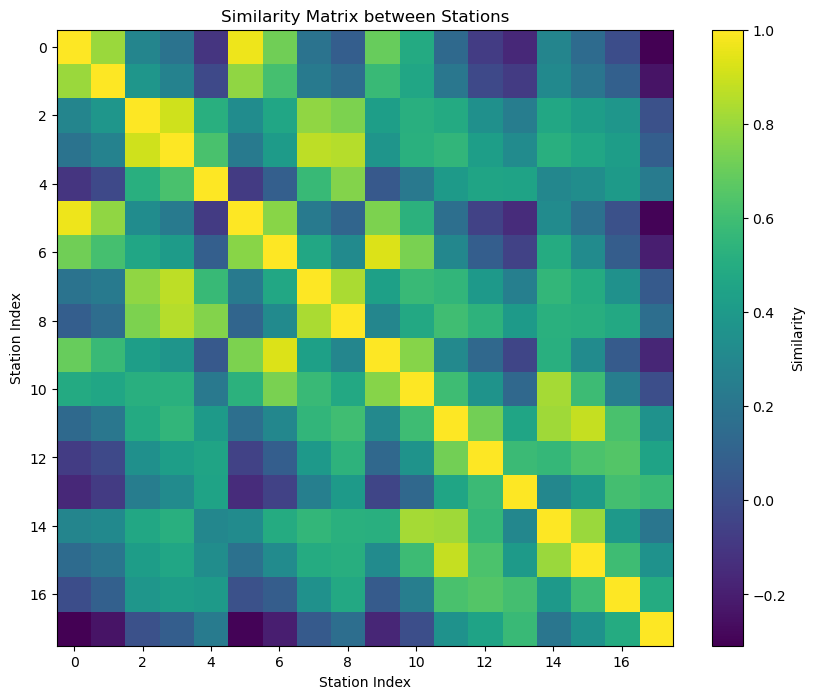

In [86]:
# Initialize an empty list to store u10 values for each station
u10_values = []

# Loop through station_data and extract u10 values from each station
for station in station_data:
    u10_values.append(station.u10)

# Compute similarity matrix using vectorized operations
similarity_matrix = np.corrcoef(u10_values)

# Visualize the similarity matrix
plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Similarity')
plt.title('Similarity Matrix between Stations')
plt.xlabel('Station Index')
plt.ylabel('Station Index')
plt.show()

array(52., dtype=float32)

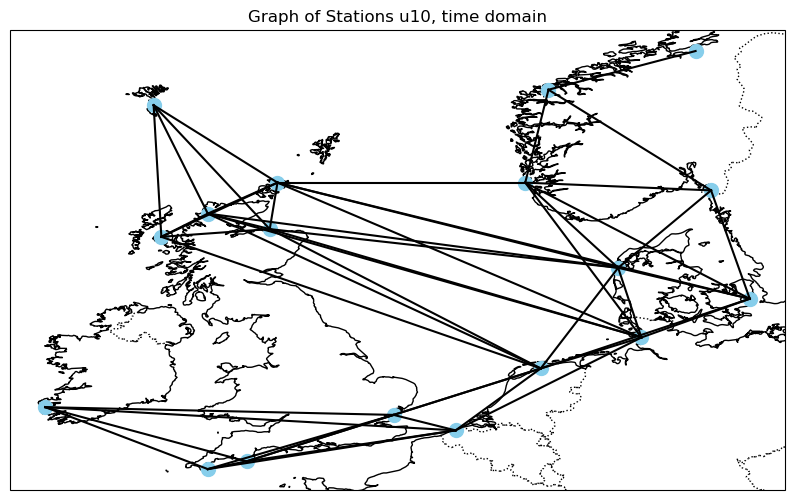

In [121]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import networkx as nx

# Initialize an empty list to store u10 values for each station
u10_values = []

# Loop through station_data and extract u10 values from each station
for station in station_data:
    u10_values.append(station.u10)

# Compute similarity matrix using vectorized operations
similarity_matrix = np.corrcoef(u10_values)

# Choose a threshold value
threshold = 0.5  # Adjust as needed

# Construct the graph based on the similarity matrix and threshold
G = nx.Graph()
num_stations = similarity_matrix.shape[0]

# Add nodes to the graph
G.add_nodes_from(range(num_stations))

# Add edges to the graph based on the similarity matrix and threshold
for i in range(num_stations):
    for j in range(i + 1, num_stations):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j)

# Create a Cartopy PlateCarree projection
projection = ccrs.PlateCarree()

# Visualize the map
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=projection)

# Add coastlines and borders
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':', linewidth=1)

# Plot nodes on the map using latitude and longitude information
for node in G.nodes():
    lat, lon = station_coords[node]  # Corrected order of latitude and longitude
    ax.plot(lon, lat, 'o', markersize=10, color='skyblue', transform=projection)

# Plot connections between nodes
for edge in G.edges():
    node1, node2 = edge
    lat1, lon1 = station_coords[node1]  # Corrected order of latitude and longitude
    lat2, lon2 = station_coords[node2]  # Corrected order of latitude and longitude
    ax.plot([lon1, lon2], [lat1, lat2], color='black', transform=projection)

# Set title and labels
plt.title("Graph of Stations u10, time domain")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()



In [126]:
station

<xarray.Dataset>
Dimensions:    (time: 219144)
Coordinates:
    longitude  float32 10.75
    latitude   float32 63.5
  * time       (time) datetime64[ns] 1990-01-01 ... 2014-12-31T23:00:00
Data variables:
    u10        (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    v10        (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    mdts       (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    mpts       (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    mwd        (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    mwp        (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    sst        (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    shts       (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    shww       (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
    sp         (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-03-15 13:42:24 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

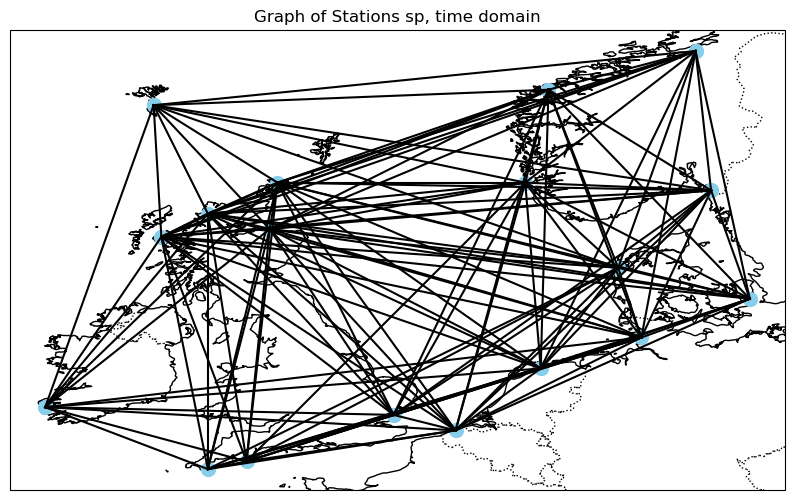

In [128]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def plot_station_graph(similarity_matrix, variable, station_coords, threshold=0.5):
    # Initialize an empty list to store u10 values for each station
    u10_values = []

    # Loop through station_data and extract u10 values from each station
    for station in station_data:
        u10_values.append(station[variable])

    # Compute similarity matrix using vectorized operations
    similarity_matrix = np.corrcoef(u10_values)

    # Choose a threshold value
    threshold = 0.5  # Adjust as needed
    
    # Construct the graph based on the similarity matrix and threshold
    G = nx.Graph()
    num_stations = similarity_matrix.shape[0]

    # Add nodes to the graph
    G.add_nodes_from(range(num_stations))

    # Add edges to the graph based on the similarity matrix and threshold
    for i in range(num_stations):
        for j in range(i + 1, num_stations):
            if similarity_matrix[i, j] > threshold:
                G.add_edge(i, j)

    # Create a Cartopy PlateCarree projection
    projection = ccrs.PlateCarree()

    # Visualize the map
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1, projection=projection)

    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':', linewidth=1)

    # Plot nodes on the map using latitude and longitude information
    for node in G.nodes():
        lat, lon = station_coords[node]  # Corrected order of latitude and longitude
        ax.plot(lon, lat, 'o', markersize=10, color='skyblue', transform=projection)

    # Plot connections between nodes
    for edge in G.edges():
        node1, node2 = edge
        lat1, lon1 = station_coords[node1]  # Corrected order of latitude and longitude
        lat2, lon2 = station_coords[node2]  # Corrected order of latitude and longitude
        ax.plot([lon1, lon2], [lat1, lat2], color='black', transform=projection)

    # Set title and labels
    plt.title(f"Graph of Stations {variable}, time domain")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Show the plot
    plt.show()

plot_station_graph(similarity_matrix, "sp", station_coords, threshold=0.5)

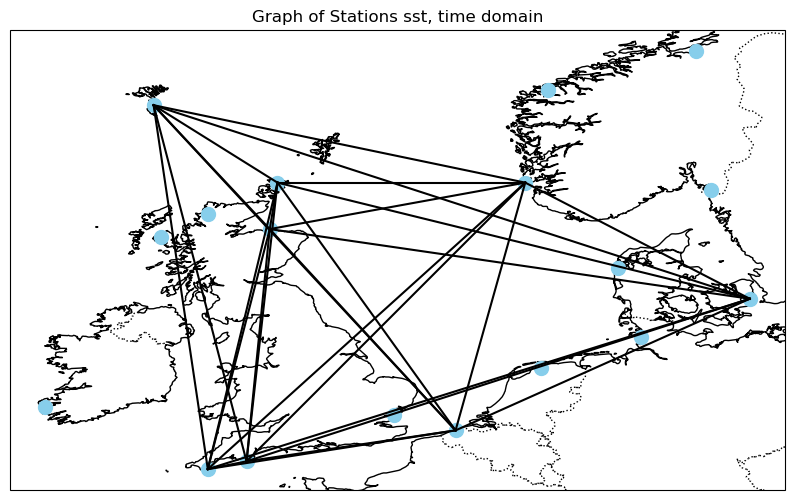

In [129]:
plot_station_graph(similarity_matrix, "sst", station_coords, threshold=0.5)

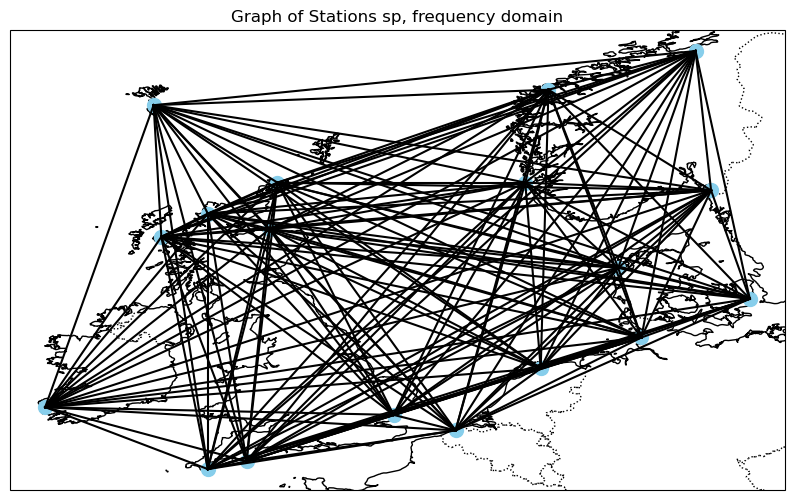

In [130]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.signal import correlate

def plot_station_graph_frequency(similarity_matrix, variable, station_coords, threshold=0.5):
    # Initialize an empty list to store u10 values for each station
    u10_values = []

    # Loop through station_data and extract u10 values from each station
    for station in station_data:
        u10_values.append(station[variable])

    # Compute Fourier transforms of the u10 values
    u10_fft = np.fft.fft(u10_values, axis=0)

    # Compute the correlation matrix in the frequency domain
    correlation_matrix = np.abs(correlate(u10_fft, u10_fft, mode='same'))

    # Choose a threshold value
    threshold = 0.5  # Adjust as needed
    
    # Construct the graph based on the correlation matrix and threshold
    G = nx.Graph()
    num_stations = correlation_matrix.shape[0]

    # Add nodes to the graph
    G.add_nodes_from(range(num_stations))

    # Add edges to the graph based on the correlation matrix and threshold
    for i in range(num_stations):
        for j in range(i + 1, num_stations):
            if correlation_matrix[i, j] > threshold:
                G.add_edge(i, j)

    # Create a Cartopy PlateCarree projection
    projection = ccrs.PlateCarree()

    # Visualize the map
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1, projection=projection)

    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':', linewidth=1)

    # Plot nodes on the map using latitude and longitude information
    for node in G.nodes():
        lat, lon = station_coords[node]  # Corrected order of latitude and longitude
        ax.plot(lon, lat, 'o', markersize=10, color='skyblue', transform=projection)

    # Plot connections between nodes
    for edge in G.edges():
        node1, node2 = edge
        lat1, lon1 = station_coords[node1]  # Corrected order of latitude and longitude
        lat2, lon2 = station_coords[node2]  # Corrected order of latitude and longitude
        ax.plot([lon1, lon2], [lat1, lat2], color='black', transform=projection)

    # Set title and labels
    plt.title(f"Graph of Stations {variable}, frequency domain")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Show the plot
    plt.show()

plot_station_graph_frequency(similarity_matrix, "sp", station_coords, threshold=0.5)

/Users/lb962/miniconda3/envs/ESL/lib/python3.12/site-packages/scipy/signal/_signaltools.py:242: RuntimeWarning: Use of fft convolution on input with NAN or inf results in NAN or inf output. Consider using method='direct' instead.
  return convolve(in1, _reverse_and_conj(in2), mode, method)


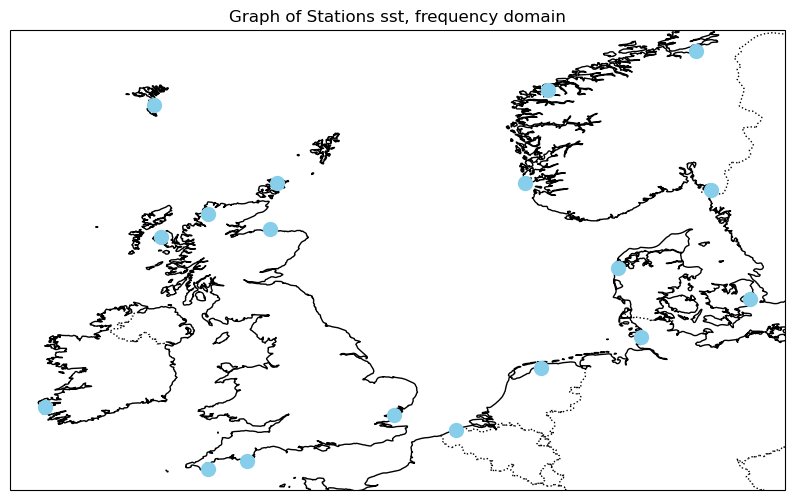

In [133]:
plot_station_graph_frequency(similarity_matrix, "sst", station_coords, threshold=0.8)

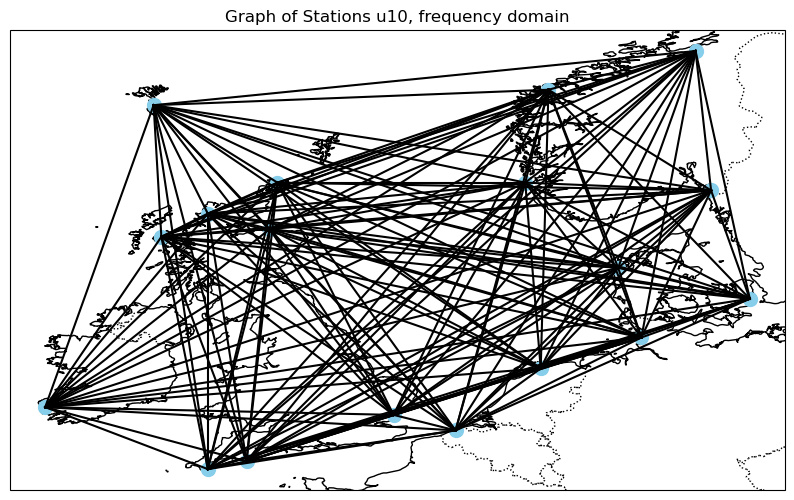

In [132]:
plot_station_graph_frequency(similarity_matrix, "u10", station_coords, threshold=0.5)

In [134]:
import numpy as np

def compute_similarity_matrix(station_data, features):
    num_stations = len(station_data)
    similarity_matrix = np.zeros((num_stations, num_stations))

    # Compute feature vectors for each station
    feature_vectors = np.array([[station[feature] for feature in features] for station in station_data])

    # Normalize feature vectors
    normalized_feature_vectors = (feature_vectors - feature_vectors.mean(axis=0)) / feature_vectors.std(axis=0)

    # Compute pairwise similarities
    for i in range(num_stations):
        for j in range(i, num_stations):
            similarity = np.dot(normalized_feature_vectors[i], normalized_feature_vectors[j])
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity  # Similarity matrix is symmetric

    return similarity_matrix


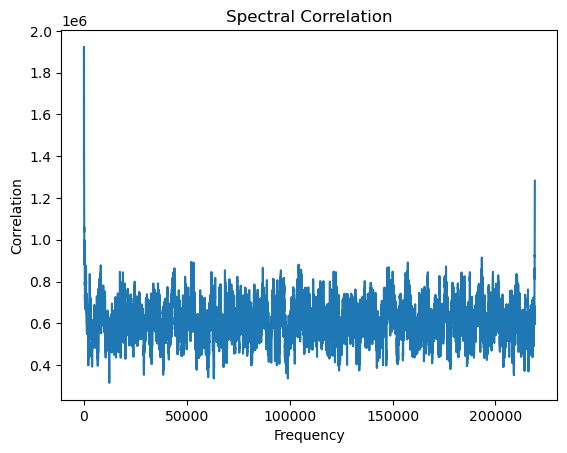

In [56]:
u10_fft = np.fft.fft(u10)
v10_fft = np.fft.fft(v10)

# Compute the cross-spectral density
cross_spectral_density = u10_fft * np.conj(v10_fft)

# Compute the spectral correlation
spectral_correlation = np.fft.ifft(cross_spectral_density)

# Plot the spectral correlation
plt.plot(np.abs(spectral_correlation))
plt.title('Spectral Correlation')
plt.xlabel('Frequency')
plt.ylabel('Correlation')
plt.show()